In [1]:
import gymnasium as gym
import numpy as np
import time
from q_learning import QL
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pclib.nn.models import FCClassifier, FCClassifierInv

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
env = gym.make('FrozenLake-v1', is_slippery=False)
ql = QL(env, 0.001, 0.9, epsilon=0.1)
ql.train(10000)
state_value = torch.tensor(ql.Q.max(1)).to(device)
print(state_value.reshape(4,4))

tensor([[3.7655e-01, 4.5738e-01, 5.3708e-01, 4.6238e-02],
        [6.6158e-04, 0.0000e+00, 6.1668e-01, 0.0000e+00],
        [5.1607e-02, 2.7041e-01, 7.0003e-01, 0.0000e+00],
        [0.0000e+00, 1.4938e-01, 7.8988e-01, 0.0000e+00]], device='cuda:0',
       dtype=torch.float64)


In [10]:
seed = 42
torch.manual_seed(seed)

model = FCClassifierInv(
    input_size=16,
    num_classes=4,
    hidden_sizes=[8],
    bias=True,
    symmetric=True,
    precision_weighted=False,
    actv_fn=F.tanh,
    steps=60,
    gamma=0.1,
).to(device)

def format_obs(obs):
    obs = F.one_hot(torch.tensor(obs), num_classes=16).float().to(device)
    baseline = torch.ones_like(obs).to(device) * 0.03
    obs = baseline + (obs * 0.94)
    return obs

optimiser = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.02)

In [7]:
num_envs = 64
# envs = gym.vector.make('FrozenLake-v1', num_envs=num_envs, asynchronous=False, is_slippery=False)
envs = gym.make_vec('FrozenLake-v1', num_envs=num_envs, is_slippery=False)
obs = format_obs(envs.observation_space.sample())
model(obs)[0].shape

torch.Size([64, 4])

In [11]:
num_epochs = 100
final_rewards = []
vfes = []
delta_Ers = []
loop = tqdm(range(num_epochs), leave=False, total=num_epochs)
for epoch in loop:
    if epoch > 0:
        loop.set_description(f"Epoch {epoch}/{num_epochs}, Reward: {final_rewards[-1]:.3f}, vfe: {vfes[-1]:.3g}, delta_Er: {delta_Ers[-1]:.3g}")
    state = envs.reset()[0]
    total_reward = [0] * num_envs
    done = np.array([False] * num_envs)
    prev_value = state_value[state]
    prev_state = state
    step = 0
    epoch_vfes = []
    epoch_deltaErs = []
    while not done.all():
        step += 1
        if step % 300 == 0:
            print(f"{terminated + truncated}, {(terminated + truncated).all()}")
        obs = format_obs(state)
        actions, s = model(obs)
        action = actions.argmax(dim=1).cpu().numpy()

        state, reward, terminated, truncated, _ = envs.step(action)
        for i, t in enumerate(terminated):
            if t:
                total_reward[i] -= 0.2
        value = state_value[state]
        total_reward += reward - 0.01
        done = done + terminated + truncated

        # reward has to be added in this env, because state set to 0 when goal is reached.
        # reward simulates state_value[final_state] as it is 1 when goal and 0 elsewhere.
        # this implementation will likely be different for other envs.
        same_state = prev_state == state
        vfe = model.vfe(s, batch_reduction=None)
        delta_Er = (value - prev_value) - (0.5 * torch.tensor(same_state).float().to(device)) + torch.tensor(reward).float().to(device)
        # delta_Er = torch.ones_like(vfe)
        loss = (vfe * delta_Er).mean()
        epoch_vfes.append(vfe.mean().item())
        epoch_deltaErs.append(delta_Er.mean().item())
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        prev_value = value
        prev_state = state
    final_rewards.append(sum(total_reward) / len(total_reward))
    vfes.append(sum(epoch_vfes) / len(epoch_vfes))
    delta_Ers.append(sum(epoch_deltaErs) / len(epoch_deltaErs))



Text(0.5, 1.0, 'Delta Er')

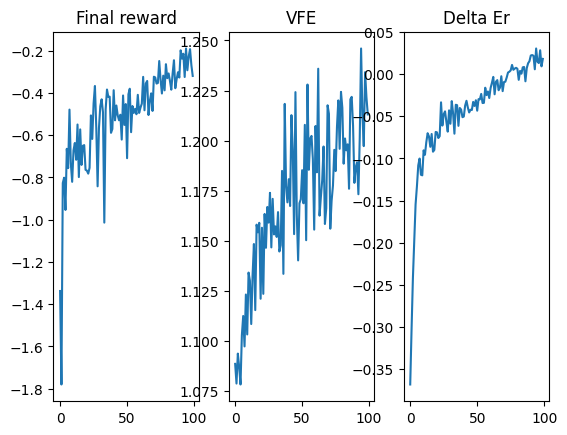

In [12]:
plt.subplot(1, 3, 1)
plt.plot(final_rewards)
plt.title("Final reward")
plt.subplot(1, 3, 2)
plt.plot(vfes)
plt.title("VFE")
plt.subplot(1, 3, 3)
plt.plot(delta_Ers)
plt.title("Delta Er")

In [ ]:
# Watch the agent play
env = gym.make('FrozenLake-v1', is_slippery=False, render_mode='human')
QL.env = env
total_rewards = []
for i in range(3):
    total_reward = 0.0
    state = env.reset()[0]
    terminated, truncated = False, False
    while not terminated and not truncated:
        action = ql.act(state)
        state, reward, terminated, truncated, _ =env.step(action)
        total_reward += reward
        env.render()
        time.sleep(0.05)
    total_rewards.append(reward)

print(f"mean reward: {np.array(total_rewards).mean()}")
env.close()

KeyboardInterrupt: 